Copyright 2023 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

     https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

In [1]:
%%capture
%pip install -U flax optax tqdm jax

# ResNet on CIFAR10 with Flax and Optax.

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/google-deepmind/optax/blob/master/examples/cifar10_resnet.ipynb)

This notebook trains a residual network (ResNet) with optax on CIFAR10 or CIFAR100.

In [2]:
import functools
from typing import Any, Callable, Sequence, Tuple, Optional, Dict

from flax import linen as nn

import jax
import jax.numpy as jnp

from tqdm.notebook import trange
from matplotlib import pyplot as plt
import numpy as np

import optax
import tensorflow as tf
import tensorflow_datasets as tfds
from functools import partial

# hide the GPU from tensorflow, otherwise it might
# reserve memory on it
tf.config.experimental.set_visible_devices([], "GPU")

# Show on which platform JAX is running.
print("JAX running on", jax.devices()[0].platform.upper())

JAX running on GPU


In [3]:
# @markdown Total number of epochs to train for:
MAX_EPOCHS = 50  # @param{type:"integer"}
# @markdown Number of samples in each batch:
BATCH_SIZE = 128  # @param{type:"integer"}
# @markdown The initial learning rate for the optimizer:
PEAK_LR = 0.12  # @param{type:"number"}
# @markdown The model architecture for the neural network. Can be one of `'resnet1'`, `'resnet18'`, `'resnet34'`, `'resnet50'`, `'resnet101'`, `'resnet152'`, `'resnet200'`:
MODEL = "resnet18"  # @param{type:"string"}
# @markdown The dataset to use. Could be either `'cifar10'` or `'cifar100'`:
DATASET = "cifar10"  # @param{type:"string"}
# @markdown The amount of L2 regularization (aka weight decay) to use:
L2_REG = 1e-4  # @param{type:"number"}

CIFAR10 and CIFAR100 are composed of 32x32 images with 3 channels (RGB). We'll now load the dataset using `tensorflow_datasets` and display a few of the first samples.

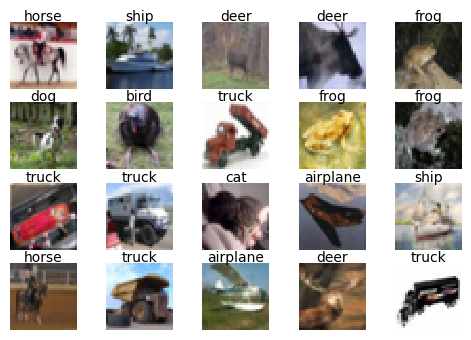

In [4]:
(train_loader, test_loader), info = tfds.load(
    DATASET, split=["train", "test"], as_supervised=True, with_info=True
)
NUM_CLASSES = info.features["label"].num_classes
IMG_SIZE = info.features["image"].shape


def plot_sample_images(loader):
  loader_iter = iter(loader)
  _, axes = plt.subplots(nrows=4, ncols=5, figsize=(6, 4))
  for i in range(4):
    for j in range(5):
      image, label = next(loader_iter)
      axes[i, j].imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
      axes[i, j].set_axis_off()
      axes[i, j].set_title(
          info.features["label"].names[label], fontsize=10, y=0.9
      )


plot_sample_images(train_loader)

The accuracy of the model can be improved significantly through data augmentation. That is, instead of training on the above images, we'll generate random modifications of the images and train on those. This is done by using the `transform` argument of `tfds.load` to apply a random crop, random horizontal flip, and random color jittering.

In the next cell we apply these transformations on the above images.

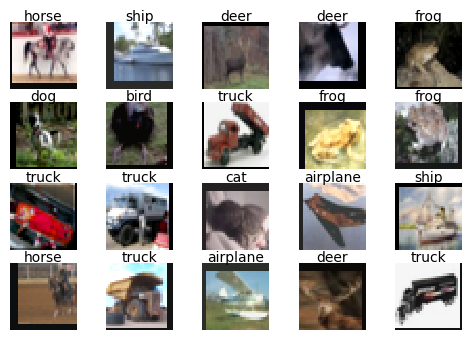

In [5]:
def augment(image, label):
  """Performs data augmentation."""
  image = tf.image.resize_with_crop_or_pad(image, 40, 40)
  image = tf.image.random_crop(image, [32, 32, 3])
  image = tf.image.random_flip_left_right(image)
  image = tf.image.random_brightness(image, max_delta=0.2)
  image = tf.image.random_contrast(image, 0.8, 1.2)
  image = tf.image.random_saturation(image, 0.8, 1.2)
  return image, label


train_loader_augmented = train_loader.map(augment)
plot_sample_images(train_loader_augmented)

We now shuffle the data in the train set and create batches of size `'BATCH_SIZE'` for both train and test set

In [6]:
train_loader_batched = train_loader_augmented.shuffle(
    buffer_size=10_000, reshuffle_each_iteration=True
).batch(BATCH_SIZE, drop_remainder=True)

test_loader_batched = test_loader.batch(BATCH_SIZE, drop_remainder=True)

Now that the data is ready, let's define the model. We will be implementing ResNet from scratch using Flax. More examples on how to use Flax can be found [here](https://github.com/google/flax/tree/main/examples).

Note that we're overwriting some of the default parameters in this implementation, such as the `kernel_shape` and `stride` of the convolutions. The default values of (7, 7) and 2 respectively are too large for the small 32x32 images in this dataset, so we reduce these parameters to (3, 3) and 1 respectively.


In [7]:
ModuleDef = Any


class ResNetBlock(nn.Module):
  """ResNet block."""

  filters: int
  conv: ModuleDef
  norm: ModuleDef
  act: Callable
  strides: Tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(
      self,
      x,
  ):
    residual = x
    y = self.conv(self.filters, (3, 3), self.strides)(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3))(y)
    y = self.norm(scale_init=nn.initializers.zeros_init())(y)

    if residual.shape != y.shape:
      residual = self.conv(self.filters, (1, 1), self.strides, name="conv_proj")(
          residual
      )
      residual = self.norm(name="norm_proj")(residual)

    return self.act(residual + y)


class BottleneckResNetBlock(nn.Module):
  """Bottleneck ResNet block."""

  filters: int
  conv: ModuleDef
  norm: ModuleDef
  act: Callable
  strides: Tuple[int, int] = (1, 1)

  @nn.compact
  def __call__(self, x):
    residual = x
    y = self.conv(self.filters, (1, 1))(x)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters, (3, 3), self.strides)(y)
    y = self.norm()(y)
    y = self.act(y)
    y = self.conv(self.filters * 4, (1, 1))(y)
    y = self.norm(scale_init=nn.initializers.zeros_init())(y)

    if residual.shape != y.shape:
      residual = self.conv(self.filters * 4, (1, 1), self.strides, name="conv_proj")(
          residual
      )
      residual = self.norm(name="norm_proj")(residual)

    return self.act(residual + y)


class ResNet(nn.Module):
  """ResNetV1."""

  stage_sizes: Sequence[int]
  block_cls: ModuleDef
  num_classes: int
  num_filters: int = 64
  dtype: Any = jnp.float32
  act: Callable = nn.relu
  conv: ModuleDef = nn.Conv
  initial_conv_config: Optional[Dict[str, Any]] = None

  @nn.compact
  def __call__(self, x, train: bool = True):
    conv = partial(self.conv, use_bias=False, dtype=self.dtype)
    norm = partial(
        nn.BatchNorm,
        use_running_average=not train,
        momentum=0.9,
        epsilon=1e-5,
        dtype=self.dtype,
    )

    initial_conv_config = dict(self.initial_conv_config)
    initial_conv_config.setdefault("kernel_size", 7)
    initial_conv_config.setdefault("strides", 2)
    initial_conv_config.setdefault("with_bias", False)
    initial_conv_config.setdefault("padding", "SAME")
    initial_conv_config.setdefault("name", "initial_conv")

    x = conv(self.num_filters, **self.initial_conv_config)(x)
    x = norm(name="bn_init")(x)
    x = nn.relu(x)
    x = nn.max_pool(x, (3, 3), strides=(2, 2), padding="SAME")
    for i, block_size in enumerate(self.stage_sizes):
      for j in range(block_size):
        strides = (2, 2) if i > 0 and j == 0 else (1, 1)
        x = self.block_cls(
            self.num_filters * 2**i,
            strides=strides,
            conv=conv,
            norm=norm,
            act=self.act,
        )(x)
    x = jnp.mean(x, axis=(1, 2))
    x = nn.Dense(self.num_classes, dtype=self.dtype)(x)
    x = jnp.asarray(x, self.dtype)
    return x


ResNet1 = partial(ResNet, stage_sizes=[1], block_cls=ResNetBlock)
ResNet18 = partial(ResNet, stage_sizes=[2, 2, 2, 2], block_cls=ResNetBlock)
ResNet34 = partial(ResNet, stage_sizes=[3, 4, 6, 3], block_cls=ResNetBlock)
ResNet50 = partial(ResNet, stage_sizes=[3, 4, 6, 3], block_cls=BottleneckResNetBlock)
ResNet101 = partial(ResNet, stage_sizes=[3, 4, 23, 3], block_cls=BottleneckResNetBlock)
ResNet152 = partial(ResNet, stage_sizes=[3, 8, 36, 3], block_cls=BottleneckResNetBlock)
ResNet200 = partial(ResNet, stage_sizes=[3, 24, 36, 3], block_cls=BottleneckResNetBlock)

In [8]:
initial_conv_config = {"kernel_size": (3, 3), "strides": 1, "padding": "SAME"}

RESNET_CONSTRUCTOR = {
    "resnet1": ResNet1,
    "resnet18": ResNet18,
    "resnet34": ResNet34,
    "resnet50": ResNet50,
    "resnet101": ResNet101,
    "resnet152": ResNet152,
    "resnet200": ResNet200,
}

net = RESNET_CONSTRUCTOR[MODEL](num_classes=NUM_CLASSES, initial_conv_config=initial_conv_config)

def predict(params, bn_params, inputs, is_training=False):
  all_params = {"params": params, "batch_stats": bn_params}

  def train_fn(inputs):
    logits, net_state = net.apply(
        all_params, inputs, train=True, mutable=["batch_stats"]
    )
    return logits, net_state

  def eval_fn(inputs):
    logits = net.apply(all_params, inputs, train=False, mutable=False)
    return logits, {"batch_stats": bn_params}

  return jax.lax.cond(
      is_training, lambda x: train_fn(x), lambda x: eval_fn(x), inputs
  )


@partial(jax.jit, static_argnums=(3,))
def loss_accuracy(params, bn_params, data, is_training: bool = True):
  """Computes loss and accuracy over a mini-batch.

  Args:
    params: parameters of the model.
    bn_params: state of the model.
    data: tuple of (inputs, labels).
    is_training: if true, uses train mode, otherwise uses eval mode.

  Returns:
    loss: float
    aux: dictionary with keys "accuracy" and "batch_stats".
  """
  inputs, labels = data
  logits, net_state = predict(params, bn_params, inputs, is_training=is_training)
  mean_loss = optax.softmax_cross_entropy_with_integer_labels(
      logits=logits, labels=labels
  ).mean()
  accuracy = jnp.mean(jnp.argmax(logits, axis=-1) == labels)
  l2_params = jax.tree_util.tree_leaves(params)
  # Computes regularization on all except batchnorm parameters.
  weight_l2 = sum(jnp.sum(x**2) for x in l2_params if x.ndim > 1)
  loss = mean_loss + 0.5 * L2_REG * weight_l2
  return loss, {"accuracy": accuracy, "batch_stats": net_state["batch_stats"]}

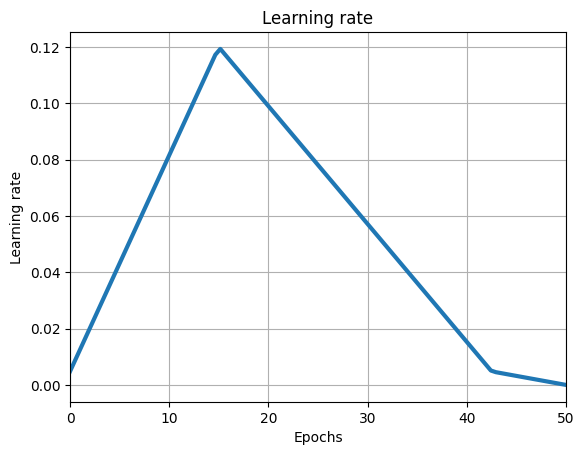

In [9]:
iter_per_epoch_train = info.splits["train"].num_examples // BATCH_SIZE
lr_schedule = optax.linear_onecycle_schedule(
    MAX_EPOCHS * iter_per_epoch_train, PEAK_LR
)

iterate_subsample = np.linspace(0, MAX_EPOCHS * iter_per_epoch_train, 100)
plt.plot(
    np.linspace(0, MAX_EPOCHS, len(iterate_subsample)),
    [lr_schedule(i) for i in iterate_subsample],
    lw=3,
)
plt.title("Learning rate")
plt.xlabel("Epochs")
plt.ylabel("Learning rate")
plt.grid()
plt.xlim((0, MAX_EPOCHS))
plt.show()

In the next two cells initialize variables and states. We also define a convenience function `dataset_stats` that we'll call once per epoch to collect the loss and accuracy of our solver over the test set.

In [10]:
solver = optax.sgd(lr_schedule, momentum=0.9, nesterov=False)

# Initializes parameters.
rng = jax.random.PRNGKey(0)
dummy_data = jnp.ones((1,) + IMG_SIZE, dtype=jnp.float32)
dummy_targets = jnp.ones(1, int)
variables = net.init({"params": rng}, dummy_data)

var_params, net_state = variables["params"], variables["batch_stats"]

In [11]:
# Defines parameter update function.
var_solver_state = solver.init(var_params)


def dataset_stats(params, net_state, data_loader):
  """Computes loss and accuracy over the dataset `data_loader`."""
  all_accuracy = []
  all_loss = []
  for cur_batch in data_loader.as_numpy_iterator():
    batch_loss, batch_aux = loss_accuracy(
        params, net_state, cur_batch, is_training=False
    )
    all_loss.append(batch_loss)
    all_accuracy.append(batch_aux["accuracy"])
  return {"loss": np.mean(all_loss), "accuracy": np.mean(all_accuracy)}

Finally, we do the actual training. The next cell performs `'MAX_EPOCHS'` epochs of training. Within each epoch we iterate over the batched loader `train_loader_batched`, and once per epoch we also compute the test set accuracy and loss.

In [12]:
train_accuracy = []
train_losses = []

# Computes test set accuracy at initialization.
test_stats = dataset_stats(var_params, net_state, test_loader_batched)
test_accuracy = [test_stats["accuracy"]]
test_losses = [test_stats["loss"]]


@jax.jit
def train_step(params, net_state, solver_state, batch):
  # Performs a one step update.
  (loss, aux), grad = jax.value_and_grad(loss_accuracy, has_aux=True)(
      params, net_state, batch, is_training=True
  )
  updates, solver_state = solver.update(grad, solver_state)
  params = optax.apply_updates(params, updates)
  return params, solver_state, loss, aux


# Executes a training loop.
for epoch in trange(MAX_EPOCHS):
  train_accuracy_epoch = []
  train_losses_epoch = []

  for train_batch in train_loader_batched.as_numpy_iterator():
    var_params, var_solver_state, train_loss, train_aux = train_step(
        var_params, net_state, var_solver_state, train_batch
    )
    net_state = train_aux["batch_stats"]
    train_accuracy_epoch.append(train_aux["accuracy"])
    train_losses_epoch.append(train_loss)

  #  Once per epoch, makes a pass over the test set to compute accuracy.
  test_stats = dataset_stats(var_params, net_state, test_loader_batched)
  test_accuracy.append(test_stats["accuracy"])
  test_losses.append(test_stats["loss"])
  train_accuracy.append(np.mean(train_accuracy_epoch))
  train_losses.append(np.mean(train_losses_epoch))

  # Prints accuracy every 10 epochs.
  if epoch % 10 == 0:
    print("Epoch: ", epoch)
    print("Test set accuracy: ", test_accuracy[-1])
    print("Train set accuracy: ", np.mean(train_accuracy_epoch))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch:  0
Test set accuracy:  0.3580729
Train set accuracy:  0.2769231
Epoch:  10
Test set accuracy:  0.6635617
Train set accuracy:  0.7901442
Epoch:  20
Test set accuracy:  0.83052886
Train set accuracy:  0.87227565
Epoch:  30
Test set accuracy:  0.8848157
Train set accuracy:  0.925
Epoch:  40
Test set accuracy:  0.9079527
Train set accuracy:  0.97241586


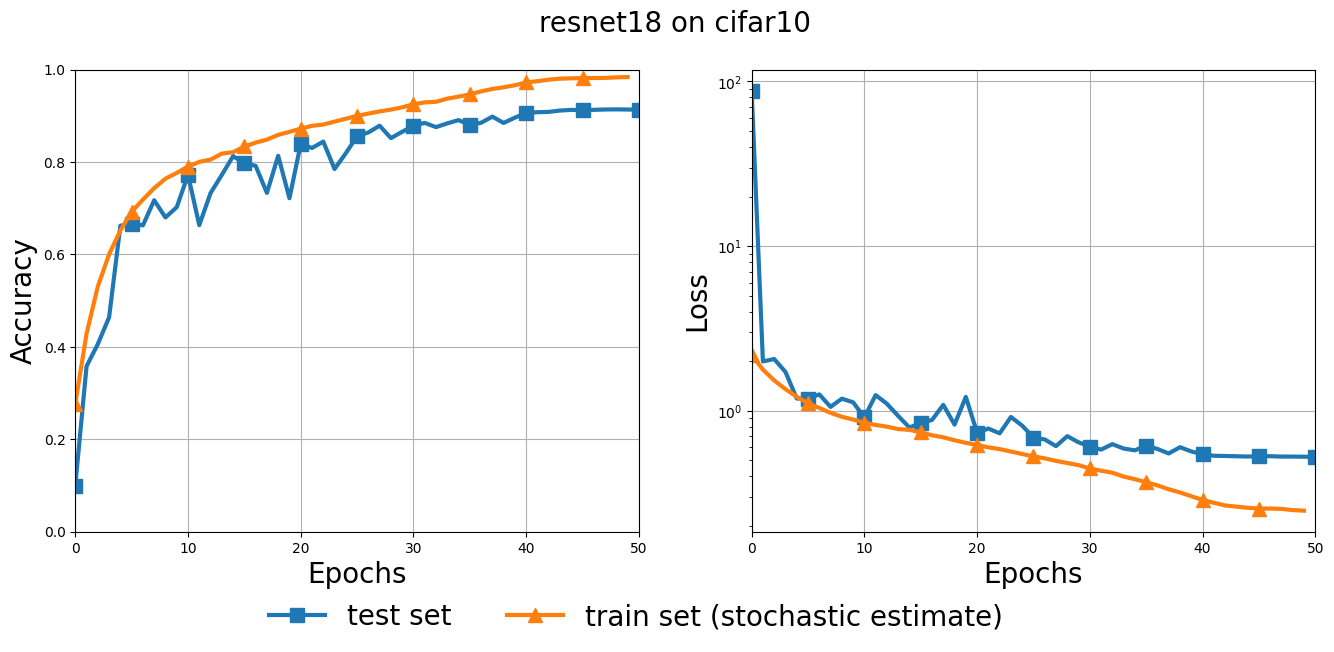

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

plt.suptitle(f"{MODEL} on {DATASET}", fontsize=20)

ax1.plot(
    test_accuracy,
    lw=3,
    marker="s",
    markevery=5,
    markersize=10,
    label="test set",
)
ax1.plot(
    train_accuracy,
    lw=3,
    marker="^",
    markevery=5,
    markersize=10,
    label="train set (stochastic estimate)",
)
ax1.set_ylabel("Accuracy", fontsize=20)
ax1.grid()
ax1.set_xlabel("Epochs", fontsize=20)
ax1.set_xlim((0, MAX_EPOCHS))
ax1.set_ylim((0, 1))

ax2.plot(
    test_losses, lw=3, marker="s", markevery=5, markersize=10, label="test set"
)
ax2.plot(
    train_losses,
    lw=3,
    marker="^",
    markevery=5,
    markersize=10,
    label="train set (stochastic estimate)",
)
ax2.set_ylabel("Loss", fontsize=20)
ax2.grid()
ax2.set_xlabel("Epochs", fontsize=20)
ax2.set_xlim((0, MAX_EPOCHS))

# set legend at the bottom of the plot
ax1.legend(
    frameon=False, fontsize=20, ncol=2, loc=2, bbox_to_anchor=(0.3, -0.1)
)

ax2.set_yscale("log")

plt.show()

In [14]:
# Finally, let's print the test set accuracy
print("Final accuracy on test set: ", test_accuracy[-1])

Final accuracy on test set:  0.9133614
